**Loading the dataset**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

%cd gdrive/My Drive/MajorProject

import cifar10

cifar10.data_path = "data/CIFAR-10/"
cifar10.maybe_download_and_extract()

class_names = cifar10.load_class_names()
images_train, cls_train, labels_train= cifar10.load_training_data()
images_test, cls_test, labels_test = cifar10.load_test_data()

x_train = images_train[0:45000]
y_train = labels_train[0:45000]


x_valid = images_train[45000:50000]
y_valid = labels_train[45000:50000]

x_test = images_test
y_test = labels_test

Mounted at /content/gdrive
/content/gdrive/My Drive/MajorProject
Data has apparently already been downloaded and unpacked.
Loading data: data/CIFAR-10/cifar-10-batches-py/batches.meta
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5
Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch


**Import Statements**

In [2]:
from keras.models import load_model, Model
from keras.optimizers import Adam
from keras.initializers import glorot_uniform
from keras.layers import Conv2D, BatchNormalization, Input, Activation, Dropout, GlobalAveragePooling2D, MaxPooling2D, Concatenate
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
import time
import pickle
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

**Building the Model**

In [ ]:
def fire_block(X, s1x1, e1x1, e3x3):

    squeeze = Conv2D(s1x1, (1, 1), strides = (1,1), padding = 'valid', kernel_initializer = glorot_uniform(seed = 0))(X)
    squeeze = Activation('relu')(squeeze)
    squeeze = BatchNormalization()(squeeze)

    expand1x1 = Conv2D(e1x1, (1, 1), strides = (1,1), padding = 'valid', kernel_initializer = glorot_uniform(seed = 0))(squeeze)
    expand1x1 = Activation('relu')(expand1x1)
    
    expand3x3 = Conv2D(e3x3, (3, 3), strides = (1,1), padding = 'same', kernel_initializer = glorot_uniform(seed = 0))(squeeze)
    expand3x3 = Activation('relu')(expand3x3)

    output = Concatenate(axis = 3)([expand1x1, expand3x3])

    return output

In [ ]:

def SqueezeNet():

    X_input = Input((32,32,3))

    X = Conv2D(96, (3, 3), strides = (2, 2),  padding = 'same', kernel_initializer = glorot_uniform(seed = 0))(X_input)
    X = Activation('relu')(X)
    X = MaxPooling2D(pool_size = (2, 2), strides = (2, 2))(X)
    X = BatchNormalization()(X)

    X = fire_block(X, 32, 128, 128)
    X = MaxPooling2D(pool_size = (3, 3), strides = (2, 2))(X)

    X = fire_block(X, 48, 192, 192)

    X = fire_block(X, 48, 192, 192)

    X = fire_block(X, 48, 192, 192)
    X = MaxPooling2D(pool_size = (3, 3), strides = (2, 2))(X)
    X = Dropout(0.5)(X)

    X = Conv2D(10, (1, 1), strides = (1, 1), padding = 'same', kernel_initializer = glorot_uniform(seed = 0))(X)
    X = Activation('relu')(X)
    X = BatchNormalization()(X)
    X = GlobalAveragePooling2D()(X)
    X = Activation('softmax')(X)
    
    model = Model(inputs = X_input, outputs = X)

    return model

In [ ]:
model = SqueezeNet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 96)   2688        input_2[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 16, 16, 96)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 8, 8, 96)     0           activation[0][0]                 
______________________________________________________________________________________________

**Augmentation**

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center = True,
        featurewise_std_normalization = True,
        rotation_range = 15,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        horizontal_flip = True)
it_train = datagen.flow(x_train, y_train, batch_size = 100)

**Training the Model**

In [ ]:
model = SqueezeNet()
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 1.0e-3), metrics = ['accuracy'])
start = time.time()
model.fit_generator(it_train, epochs = 1, validation_data = (x_valid, y_valid))
end = time.time()

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


450/450 [==============================] - 64s 81ms/step - loss: 1.9961 - accuracy: 0.2840 - val_loss: 2.6390 - val_accuracy: 0.2174


In [ ]:
model = SqueezeNet()
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 1.0e-3), metrics = ['accuracy'])
history = history = model.fit_generator(it_train, epochs = 200, validation_data = (x_valid, y_valid))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/200
450/450 [==============================] - 40s 80ms/step - loss: 2.0726 - accuracy: 0.2593 - val_loss: 2.6989 - val_accuracy: 0.2196
Epoch 2/200
450/450 [==============================] - 35s 78ms/step - loss: 1.4753 - accuracy: 0.5015 - val_loss: 1.5256 - val_accuracy: 0.4924
Epoch 3/200
450/450 [==============================] - 35s 77ms/step - loss: 1.2849 - accuracy: 0.5792 - val_loss: 1.8241 - val_accuracy: 0.4080
Epoch 4/200
450/450 [==============================] - 35s 77ms/step - loss: 1.1567 - accuracy: 0.6237 - val_loss: 1.4153 - val_accuracy: 0.5546
Epoch 5/200
450/450 [==============================] - 35s 78ms/step - loss: 1.0466 - accuracy: 0.6531 - val_loss: 0.9197 - val_accuracy: 0.6852
Epoch 6/200
450/450 [==============================] - 35s 78ms/step - loss: 0.9573 - accuracy: 0.6761 - val_loss: 1.0160 - val_accuracy: 0.6520
Epoch 7/200
450/450 [==============================] - 35s 78ms/step - loss: 0.9043 - accuracy: 0.6930 - val_loss: 0.8817 - val_ac

**Saving the Model, History and Time**

In [ ]:
model.save('SqueezeNetAug.h5')

In [ ]:
np.save('SqueezeNetAug_history.npy', history.history)

In [ ]:
with open('SqueezeNetAug_time.pkl', 'wb') as f:
    pickle.dump(round(end - start), f)

**Training Analysis**

In [3]:
with open('SqueezeNetAug_time.pkl', 'rb') as f: 
    time_loaded = pickle.load(f)
print("Time taken for training (1 epoch): ", time_loaded, "seconds")

Time taken for training (1 epoch):  65 seconds


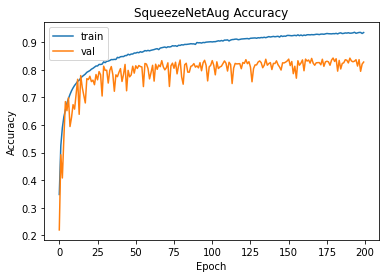

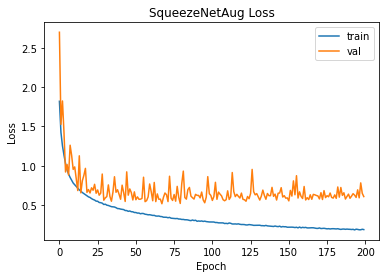

In [4]:
history_loaded = np.load('SqueezeNetAug_history.npy', allow_pickle = 'TRUE').item()

plt.plot(history_loaded['accuracy'])
plt.plot(history_loaded['val_accuracy'])
plt.title('SqueezeNetAug Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

plt.plot(history_loaded['loss'])
plt.plot(history_loaded['val_loss'])
plt.title('SqueezeNetAug Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

**Testing Analysis**

In [6]:
model_loaded = load_model('SqueezeNetAug.h5')
y_pred = model_loaded.predict(x_test)

In [7]:
def convert(y):
  return [np.argmax(i) for i in y]

y_pred_class = convert(y_pred)
y_true_class = convert(y_test)

**********Accuracy**********

 81.83 %


**********Classification Report***********

               precision    recall  f1-score   support

           0       0.88      0.81      0.84      1000
           1       0.88      0.93      0.91      1000
           2       0.81      0.79      0.80      1000
           3       0.72      0.55      0.62      1000
           4       0.89      0.73      0.80      1000
           5       0.61      0.88      0.72      1000
           6       0.88      0.87      0.87      1000
           7       0.85      0.85      0.85      1000
           8       0.88      0.90      0.89      1000
           9       0.87      0.89      0.88      1000

    accuracy                           0.82     10000
   macro avg       0.83      0.82      0.82     10000
weighted avg       0.83      0.82      0.82     10000



**********Confusion Matrix***********




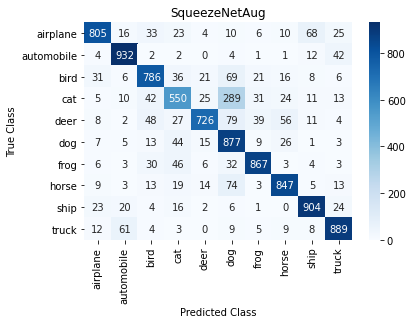

In [8]:
print("**********Accuracy**********\n\n", accuracy_score(y_true_class, y_pred_class) * 100, "%")
print("\n\n**********Classification Report***********\n\n", classification_report(y_true_class, y_pred_class))
print("\n\n**********Confusion Matrix***********\n\n")
sns.heatmap(confusion_matrix(y_true_class, y_pred_class), annot = True, fmt = 'd', cmap = 'Blues', xticklabels = class_names, yticklabels = class_names)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('SqueezeNetAug')
plt.show()